<a href="https://colab.research.google.com/github/Zufaroro/AI-image-classification/blob/main/Tubes_AI_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn matplotlib numpy opencv-python

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import os
import numpy as np
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

def process_image(img_path, class_idx, target_size=(224, 224)):
    """Memproses satu gambar menjadi array dan menambahkan labelnya."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return img_array, class_idx

def load_data(dataset_path, target_size=(224, 224)):
    """Memuat dataset secara paralel untuk mempercepat proses."""
    images = []
    labels = []
    class_names = os.listdir(dataset_path)

    # Membuat daftar semua gambar dan labelnya
    tasks = []
    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            tasks.append((img_path, class_idx))

    # Menggunakan ThreadPoolExecutor untuk mempercepat proses
    with ThreadPoolExecutor() as executor:
        results = executor.map(lambda x: process_image(x[0], x[1], target_size), tasks)

    # Memisahkan hasil menjadi gambar dan label
    for img_array, label in results:
        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels), class_names

# Path dataset
dataset_path = '/content/drive/MyDrive/Tubes AI'

# Memuat data
images, labels, class_names = load_data(dataset_path)
print(f"Loaded {len(images)} images across {len(class_names)} classes.")


Loaded 1027 images across 4 classes.


In [ ]:
np.savez('processed_dataset.npz', images=images, labels=labels)


In [ ]:
data = np.load('processed_dataset.npz')
images = data['images']
labels = data['labels']


In [ ]:
import cv2

def process_image_cv(img_path, class_idx, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img, class_idx


In [ ]:
# Konfigurasi Stratified K-Fold
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# Hasil evaluasi
fold_accuracies = []
all_y_true = []
all_y_pred = []

In [ ]:
# Preprocessing di awal
y_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# Load model sekali
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

# Tambahkan lapisan fully connected
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(images, labels)):
    print(f"Training Fold {fold + 1}")

    # Split data
    X_train, X_val = images[train_idx], images[val_idx]
    y_train_one_hot, y_val_one_hot = y_one_hot[train_idx], y_one_hot[val_idx]

    # Training model
    model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32, verbose=1)

    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val, batch_size=128)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    # Evaluasi
    acc = accuracy_score(labels[val_idx], y_val_pred_classes)
    fold_accuracies.append(acc)
    all_y_true.extend(labels[val_idx])
    all_y_pred.extend(y_val_pred_classes)
    print(f"Accuracy Fold {fold + 1}: {acc}")


NameError: name 'tf' is not defined

Training Fold 1
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4823 - loss: 106.1589 - val_accuracy: 0.5485 - val_loss: 6.7451
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.2343 - loss: 12.0290 - val_accuracy: 0.4854 - val_loss: 1.1554
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.2973 - loss: 1.2633 - val_accuracy: 0.5728 - val_loss: 1.0247
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.4061 - loss: 1.2693 - val_accuracy: 0.6214 - val_loss: 0.9587
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.3973 - loss: 1.0689 - val_accuracy: 0.5777 - val_loss: 1.0638


Model untuk Fold 1 disimpan di model_fold_1.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Accuracy Fold 1: 0.5776699029126213
Training Fold 2
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.3501 - loss: 1.1926 - val_accuracy: 0.6262 - val_loss: 0.8599
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.4242 - loss: 1.0342 - val_accuracy: 0.6845 - val_loss: 0.7756
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.5011 - loss: 0.9317 - val_accuracy: 0.7233 - val_loss: 0.7106
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.5586 - loss: 0.8306 - val_accuracy: 0.7573 - val_loss: 0.6478
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.5311 - loss: 0.8563 - val_accuracy: 0.7330 - val_loss: 0.6841


Model untuk Fold 2 disimpan di model_fold_2.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
Accuracy Fold 2: 0.7330097087378641
Training Fold 3
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 989ms/step - accuracy: 0.5944 - loss: 0.8168 - val_accuracy: 0.7220 - val_loss: 0.7090
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.5785 - loss: 0.7818 - val_accuracy: 0.7171 - val_loss: 0.7116
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.6189 - loss: 0.7720 - val_accuracy: 0.7268 - val_loss: 0.6932
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6319 - loss: 0.7188 - val_accuracy: 0.7268 - val_loss: 0.6942
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6610 - loss: 0.6750 - val_accuracy: 0.7220 - val_loss: 0.6901


Model untuk Fold 3 disimpan di model_fold_3.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Accuracy Fold 3: 0.7219512195121951
Training Fold 4
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.6564 - loss: 0.6564 - val_accuracy: 0.7854 - val_loss: 0.6079
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6574 - loss: 0.6540 - val_accuracy: 0.7902 - val_loss: 0.6004
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.6411 - loss: 0.6946 - val_accuracy: 0.7902 - val_loss: 0.5977
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.6658 - loss: 0.6426 - val_accuracy: 0.7902 - val_loss: 0.5962
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6455 - loss: 0.6693 - val_accuracy: 0.7902 - val_loss: 0.5979


Model untuk Fold 4 disimpan di model_fold_4.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Accuracy Fold 4: 0.7902439024390244
Training Fold 5
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.6534 - loss: 0.6449 - val_accuracy: 0.7707 - val_loss: 0.6349
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6558 - loss: 0.6451 - val_accuracy: 0.7707 - val_loss: 0.6316
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.6521 - loss: 0.6439 - val_accuracy: 0.7707 - val_loss: 0.6287
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6478 - loss: 0.6553 - val_accuracy: 0.7707 - val_loss: 0.6261
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6801 - loss: 0.5980 - val_accuracy: 0.7707 - val_loss: 0.6238


Model untuk Fold 5 disimpan di model_fold_5.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Accuracy Fold 5: 0.7707317073170732


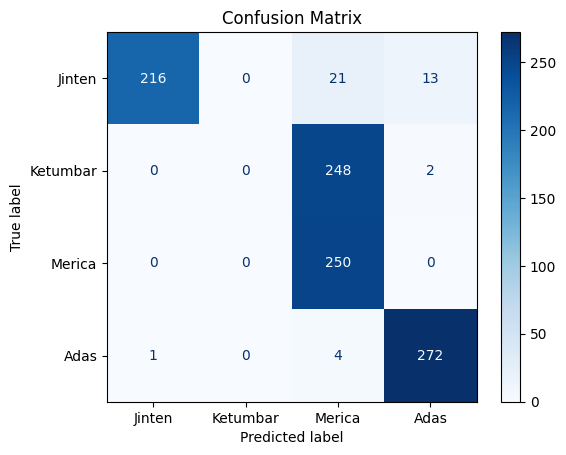

Cross-Validation Accuracies: [0.5776699029126213, 0.7330097087378641, 0.7219512195121951, 0.7902439024390244, 0.7707317073170732]
Mean Accuracy: 0.7187212881837555

Upload gambar baru untuk prediksi:


Saving tes_ai.png to tes_ai.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Gambar: tes_ai.png
Hasil Prediksi: Ketumbar (Confidence: 0.28)


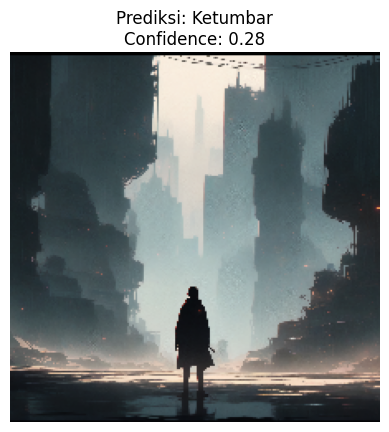

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from google.colab import files

# Preprocessing di awal
y_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# Load model sekali
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

# Tambahkan lapisan fully connected
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Cross-validation loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
all_y_true = []
all_y_pred = []

for fold, (train_idx, val_idx) in enumerate(kf.split(images, labels)):
    print(f"Training Fold {fold + 1}")

    # Split data
    X_train, X_val = images[train_idx], images[val_idx]
    y_train_one_hot, y_val_one_hot = y_one_hot[train_idx], y_one_hot[val_idx]

    # Cache data for faster loading
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
    val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Training model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,  # Kurangi epochs untuk pengujian cepat
        verbose=1
    )

    # Simpan model untuk tiap fold
    model_path = f"model_fold_{fold + 1}.h5"
    model.save(model_path)
    print(f"Model untuk Fold {fold + 1} disimpan di {model_path}")

    # Prediksi pada data validasi
    y_val_pred = model.predict(val_dataset, batch_size=128)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    # Evaluasi
    acc = accuracy_score(labels[val_idx], y_val_pred_classes)
    fold_accuracies.append(acc)
    all_y_true.extend(labels[val_idx])
    all_y_pred.extend(y_val_pred_classes)
    print(f"Accuracy Fold {fold + 1}: {acc}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Akurasi Total
print(f"Cross-Validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)}")

# Upload dan prediksi gambar baru
print("\nUpload gambar baru untuk prediksi:")
uploaded = files.upload()  # Unggah gambar melalui Google Colab interface

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img_path = filename
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Ubah ukuran gambar
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Konversi ke array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi dan tambahkan batch dimension

    # Prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]  # Kelas hasil prediksi
    confidence = np.max(predictions)  # Probabilitas prediksi

    # Tampilkan hasil
    print(f"\nGambar: {filename}")
    print(f"Hasil Prediksi: {predicted_class} (Confidence: {confidence:.2f})")

    # Visualisasi gambar dan hasil
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()


In [ ]:
# Akurasi Total
print(f"Cross-Validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)}")

# Upload dan prediksi gambar baru
print("\nUpload gambar baru untuk prediksi:")
uploaded = files.upload()  # Unggah gambar melalui Google Colab interface

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img_path = filename
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Ubah ukuran gambar
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Konversi ke array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi dan tambahkan batch dimension

    # Prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]  # Kelas hasil prediksi
    confidence = np.max(predictions)  # Probabilitas prediksi

    # Tampilkan hasil
    print(f"\nGambar: {filename}")
    print(f"Hasil Prediksi: {predicted_class} (Confidence: {confidence:.2f})")

    # Visualisasi gambar dan hasil
    plt.imshow(tf.keras.preprocessing.image.arra`y_to_img(img_array[0]))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()


Cross-Validation Accuracies: [0.5776699029126213, 0.7330097087378641, 0.7219512195121951, 0.7902439024390244, 0.7707317073170732]
Mean Accuracy: 0.7187212881837555

Upload gambar baru untuk prediksi:


Saving merica (198).jpg to merica (198).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Gambar: merica (198).jpg
Hasil Prediksi: Merica (Confidence: 0.28)


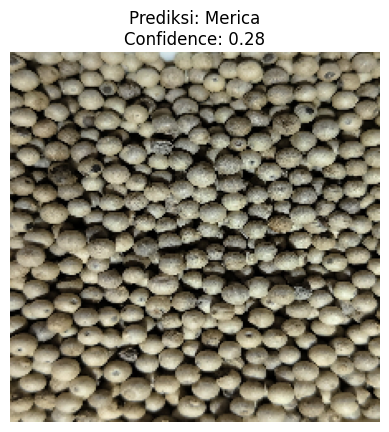

In [ ]:
# Akurasi Total
print(f"Cross-Validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)}")

# Upload dan prediksi gambar baru
print("\nUpload gambar baru untuk prediksi:")
uploaded = files.upload()  # Unggah gambar melalui Google Colab interface

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img_path = filename
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Ubah ukuran gambar
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Konversi ke array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi dan tambahkan batch dimension

    # Prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]  # Kelas hasil prediksi
    confidence = np.max(predictions)  # Probabilitas prediksi

    # Tampilkan hasil
    print(f"\nGambar: {filename}")
    print(f"Hasil Prediksi: {predicted_class} (Confidence: {confidence:.2f})")

    # Visualisasi gambar dan hasil
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()


Training Fold 1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 462ms/step - accuracy: 0.5313 - loss: 1.0896 - val_accuracy: 0.9466 - val_loss: 0.2001
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - accuracy: 0.8553 - loss: 0.3704 - val_accuracy: 0.9515 - val_loss: 0.1302
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 322ms/step - accuracy: 0.9020 - loss: 0.2718 - val_accuracy: 0.9660 - val_loss: 0.1020
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.9425 - loss: 0.1794 - val_accuracy: 0.9757 - val_loss: 0.0770
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.9469 - loss: 0.1575 - val_accuracy: 0.9757 - val_loss: 0.0795
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.9599 - loss: 0.1182 - val_accuracy: 0.9709 - val_loss: 0.0670
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.9426 - loss: 0.1286 - val_accuracy: 0.9806 - val_loss: 0.0561
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.9761 - loss: 0.0962 - val_accuracy: 0.980

Model untuk Fold 1 disimpan di model_fold_1.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 26s/step
Accuracy Fold 1: 0.9854368932038835
Training Fold 2
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.9774 - loss: 0.0745 - val_accuracy: 0.9903 - val_loss: 0.0264
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.9722 - loss: 0.0691 - val_accuracy: 0.9903 - val_loss: 0.0250
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.9779 - loss: 0.0621 - val_accuracy: 1.0000 - val_loss: 0.0182
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.9823 - loss: 0.0634 - val_accuracy: 0.9903 - val_loss: 0.0277
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 392ms/step - accuracy: 0.9777 - loss: 0.0662 - val_accuracy: 0.9854 - val_loss: 0.0350
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - accuracy: 0.9723 - loss: 0.0855 - val_accuracy: 0.9951 - val_loss: 0.0278
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - accuracy: 0.9763 - loss: 0.0664 - val_accuracy: 1.0000 - val_loss: 0.0135
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - accuracy: 0.9696 - loss: 0.0755 - val_accuracy: 0.990

Model untuk Fold 2 disimpan di model_fold_2.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Accuracy Fold 2: 0.9902912621359223
Training Fold 3
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - accuracy: 0.9733 - loss: 0.0739 - val_accuracy: 0.9805 - val_loss: 0.0340
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.9658 - loss: 0.0717 - val_accuracy: 0.9951 - val_loss: 0.0260
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9842 - loss: 0.0492 - val_accuracy: 0.9805 - val_loss: 0.0371
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.9846 - loss: 0.0478 - val_accuracy: 0.9854 - val_loss: 0.0377
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.9772 - loss: 0.0566 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.9838 - loss: 0.0604 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - accuracy: 0.9906 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.9903 - loss: 0.0321 - val_accuracy: 0.985

Model untuk Fold 3 disimpan di model_fold_3.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
Accuracy Fold 3: 1.0
Training Fold 4
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - accuracy: 0.9897 - loss: 0.0465 - val_accuracy: 0.9902 - val_loss: 0.0225
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy: 0.9796 - loss: 0.0462 - val_accuracy: 0.9902 - val_loss: 0.0193
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.9882 - loss: 0.0457 - val_accuracy: 0.9951 - val_loss: 0.0132
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - accuracy: 0.9860 - loss: 0.0329 - val_accuracy: 0.9951 - val_loss: 0.0070
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.9934 - loss: 0.0278 - val_accuracy: 0.9902 - val_loss: 0.0184
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9857 - loss: 0.0386 - val_accuracy: 0.9951 - val_loss: 0.0072
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.9880 - loss: 0.0541 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9820 - loss: 0.0510 - val_accuracy: 0.995

Model untuk Fold 4 disimpan di model_fold_4.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
Accuracy Fold 4: 0.9951219512195122
Training Fold 5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.9937 - loss: 0.0267 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.9884 - loss: 0.0507 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step - accuracy: 0.9918 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 322ms/step - accuracy: 0.9885 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.9895 - loss: 0.0320 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.9869 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9944 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - accuracy: 0.9894 - loss: 0.0299 - val_accuracy: 1.000

Model untuk Fold 5 disimpan di model_fold_5.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Accuracy Fold 5: 1.0


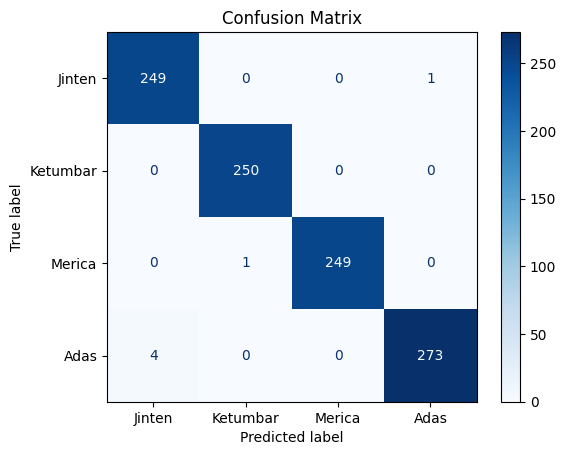

Cross-Validation Accuracies: [0.9854368932038835, 0.9902912621359223, 1.0, 0.9951219512195122, 1.0]
Mean Accuracy: 0.9941700213118636

Upload gambar baru untuk prediksi:


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from google.colab import files

# Augmentasi data
data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing di awal
y_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# Load model sekali
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

# Tambahkan lapisan fully connected
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Cross-validation loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
all_y_true = []
all_y_pred = []

for fold, (train_idx, val_idx) in enumerate(kf.split(images, labels)):
    print(f"Training Fold {fold + 1}")

    # Split data
    X_train, X_val = images[train_idx], images[val_idx]
    y_train_one_hot, y_val_one_hot = y_one_hot[train_idx], y_one_hot[val_idx]

    # Augmentasi pada data pelatihan
    train_gen = data_gen.flow(X_train, y_train_one_hot, batch_size=32)

    # Training model
    history = model.fit(
        train_gen,
        validation_data=(X_val / 255.0, y_val_one_hot),
        epochs=10,  # Tingkatkan epochs untuk performa lebih baik
        batch_size=32,
        verbose=1
    )

    # Simpan model untuk tiap fold
    model_path = f"model_fold_{fold + 1}.h5"
    model.save(model_path)
    print(f"Model untuk Fold {fold + 1} disimpan di {model_path}")

    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val / 255.0, batch_size=128)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    # Evaluasi
    acc = accuracy_score(labels[val_idx], y_val_pred_classes)
    fold_accuracies.append(acc)
    all_y_true.extend(labels[val_idx])
    all_y_pred.extend(y_val_pred_classes)
    print(f"Accuracy Fold {fold + 1}: {acc}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Akurasi Total
print(f"Cross-Validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)}")

# Upload dan prediksi gambar baru
print("\nUpload gambar baru untuk prediksi:")
uploaded = files.upload()  # Unggah gambar melalui Google Colab interface

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img_path = filename
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Ubah ukuran gambar
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Konversi ke array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi dan tambahkan batch dimension

    # Prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]  # Kelas hasil prediksi
    confidence = np.max(predictions)  # Probabilitas prediksi

    # Tampilkan hasil
    print(f"\nGambar: {filename}")
    print(f"Hasil Prediksi: {predicted_class} (Confidence: {confidence:.2f})")

    # Visualisasi gambar dan hasil
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
